In [2]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import spectral_cube
import aplpy
from math import ceil
import pyspeckit
import colorcet
import matplotlib as mpl

import sys
sys.path.append('/Users/abarnes/GitHub/misc/')
from data_cube_analysis import getdata, rms, masks, moments

plt.style.use('paper')

In [4]:
ls /Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble

cs21.TP_7M_12M_weighted_mosaic.K.kms.fits*
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.max.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom0.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom0_s2n.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom1.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.rms.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic.sigma.fits
cs21.TP_7M_12M_weighted_mosaic.K.kms.galactic_chans.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.fits*
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.max.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom0.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom0_s2n.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.mom1.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.rms.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic.sigma.fits
h13cn10.TP_7M_12M_weighted_mosaic.K.kms.galactic_chan

In [5]:
inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/hco+10.TP_7M_12M_weighted_mosaic.K.kms.galactic.fits'
print(inputfile)
hdu = fits.open(inputfile)[0]
print(hdu)

/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/hco+10.TP_7M_12M_weighted_mosaic.K.kms.galactic.fits


In [6]:
def get_channel_maps(inputfile, start=-200, stop=200, step=20):
    """
    This function calculates the zeroth moment (total intensity) for each velocity channel in a data cube,
    and writes the results to a FITS file.

    Args:
    inputfile (str): Path to the input FITS file.
    cube (SpectralCube): The data cube from which the channel maps are to be extracted.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """

    # Use the get_cube function from the getdata module to extract the data cube from the FITS file.
    cube = getdata.get_cube(inputfile)
    
    # Define the velocity channels.
    channels = np.arange(start, stop, step) *u.km/u.s

    # Get the number of channels.
    n = len(channels)-1

    # Initialize an array to hold the channel map data.
    channelmaps_data = ['']*(n)

    # For each channel...
    for i in range(n): 

        # ...extract the cube for that channel...
        cube_channels = cube.spectral_slab(channels[i], channels[i+1])

        # ...and calculate the zeroth moment, storing the result in the array.
        channelmaps_data[i] = cube_channels.moment0().hdu.data
        channelmaps_data[i][channelmaps_data[i] == 0] = np.nan

    # Get the FITS header from the last cube's zeroth moment.
    channelmaps_header = cube_channels.moment0().hdu.header

    # Create a FITS HDU using the channel map data and the header.
    channelmaps_hdu = fits.PrimaryHDU(channelmaps_data, channelmaps_header)

    # Define the output file name by removing '.fits' from the input file name.
    outputfile = inputfile.replace('.fits', '')
 
    # Write the HDU to a FITS file.
    channelmaps_hdu.writeto('%s_chans.fits' %outputfile, overwrite=True)

    return(channelmaps_hdu)

In [7]:
def plot_channel_maps(channelmaps_hdu, outputfile=None, start=-200, stop=200, step=20, contour_levels=None, vmin=None, vmax=None):
    """
    This function plots all the channel maps contained in a FITS HDU in a grid with a specified number of columns.
    It shows the velocity range in the upper right corner of each plot.

    Args:
    channelmaps_hdu (HDU): The FITS HDU containing the channel maps.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """
    # Determine the number of channels from the FITS HDU.
    channels = channelmaps_hdu.header['NAXIS3']

    # Determine the number of rows needed for the plot grid.
    rows = ceil(channels / 5)  # 4 is the number of columns.

    # Initialize the plot figure.
    fig = plt.figure(figsize=(16,16*(rows/5)))
    
    # aligning with mopra images
    l = 0.8065474
    b = -0.1999737
    width = 0.2*0.9
    height = 0.2*0.9
    
    # for contours
    col_density = '../data/multiwavelength/regrid_crop/gaussfit_iter_beta175_column_gc_itervar_conv25.fits'
    
    # For each channel...
    for chan in range(channels):
        
        # ...create a copy of the FITS HDU...
        channelmaps_hdu_ = channelmaps_hdu.copy()
        
        # ...replace the data in the HDU with the data for the current channel...
        channelmaps_hdu_.data = channelmaps_hdu_.data[chan]
        
        # ...create a subplot in the appropriate position in the grid...
        gc = aplpy.FITSFigure(channelmaps_hdu_, subplot=(rows, 5, chan+1), figure=fig)  # 4 columns
        gc.recenter(l, b, width=width, height=height)
        
        # ...display the channel map in grayscale and with contours...
        # gc.show_grayscale()
        gc.show_colorscale(cmap='inferno', vmin=vmin, vmax=vmax)
        # gc.show_contour(channelmaps_hdu_, levels=5)
        
        # Remove ticks etc
        gc.axis_labels.hide()
        gc.tick_labels.hide()
        gc.ticks.set_color('black')
        gc.ticks.set_linewidth(2)
        gc.set_nan_color('lightgrey')

        # ...and display the velocity range in the upper right corner.
        velo_range = f"{start + chan*step} to {start + (chan+1)*step} km/s"
        gc.add_label(0.25, 0.9, velo_range, relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=0.75))
        
        # adding hershel column density contours
        if contour_levels!=None:
            gc.show_contour(col_density, levels=contour_levels, linewidths=0.9, colors='white')
            
        gc.show_ellipses(0.8119, -0.1868, 240/3600, 240/3600, edgecolor='white', linestyles='dotted', linewidths=2)
        
    
    # Adjust the subplot layout to reduce space between subplots
    fig.tight_layout(h_pad=0, w_pad=-0.6)
    plt.subplots_adjust(wspace=-0.06, hspace=0)
    
    # Save the figure. 
    if outputfile != None: 
        fig.savefig(outputfile, bbox_inches='tight')
    
    return()

In [8]:
channelmaps_hdu = get_channel_maps(inputfile, 
                                   start=-30, 
                                   stop=130, 
                                   step=10)

In [9]:
# ensuring plotting over same scale
data = channelmaps_hdu.data.copy()
vmin, vmax = np.nanpercentile(data, [0.1,99.9])
print(vmin, vmax)


-12.070392592430114 24.0401634159089


()

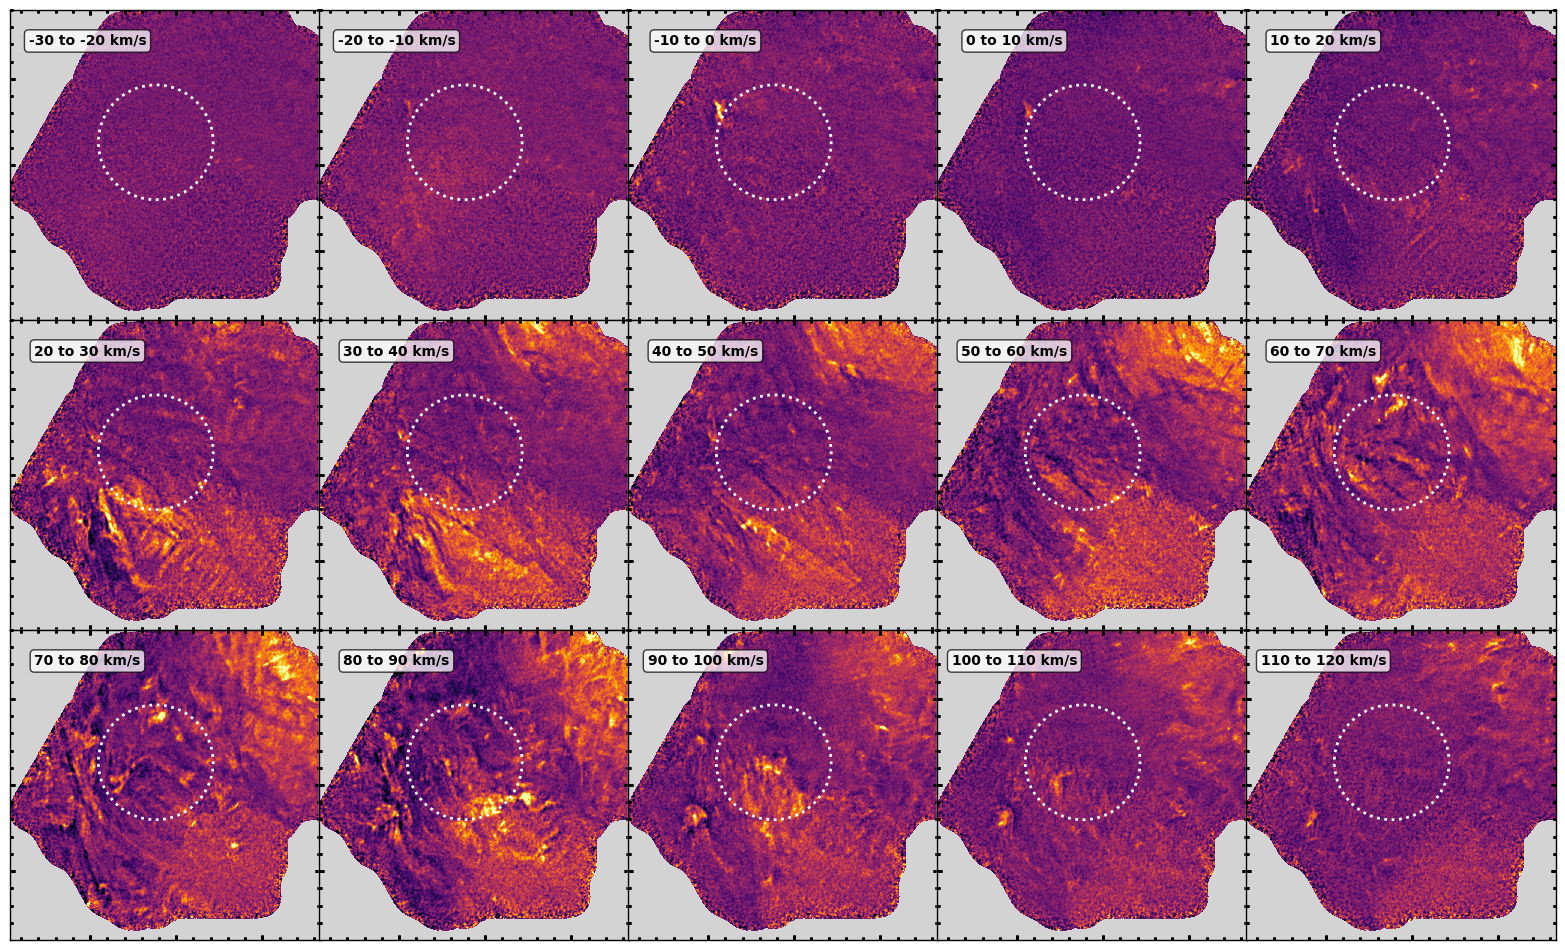

In [10]:
outputfile = '../figures/hcop_chans.pdf'

plot_channel_maps(channelmaps_hdu, 
                  start = -30, 
                  stop = 130, 
                  step = 10, 
                  vmin = vmin, 
                  vmax = vmax, 
                  outputfile = outputfile)